# Используя данные о школьниках, выявить степень их алкогольной зависимости.

## План : 
1) Визуализировать данные и выделить признаки
 
2) Обучить модель на этих прзнаках
 
3) Попробовать улучшить предсказания модели

In [1]:
#Подключаем библиотеки
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Подготовим данные и посмотрим на таблицу корреляций

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5]), <a list of 16 Text yticklabel objects>)

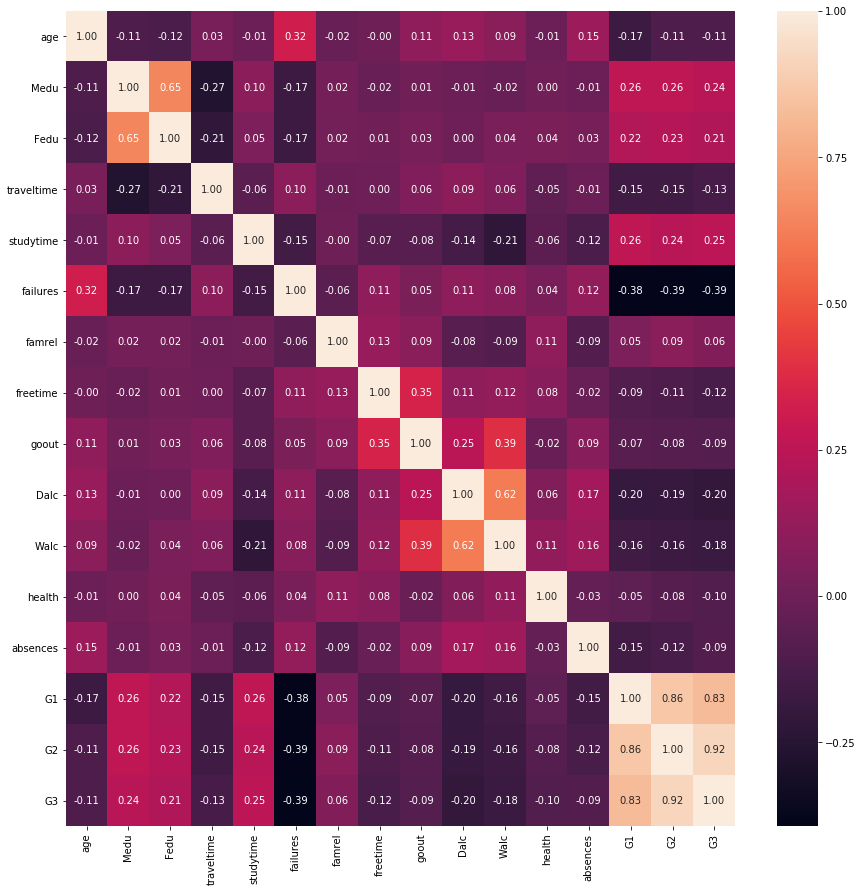

In [2]:
#prepare data
Data = pd.read_csv("/Users/tomininvladislav/Downloads/student-por.csv")
plt.figure(figsize=(15,15))
sns.heatmap(Data.corr(),annot = True,fmt = ".2f")
plt.yticks(rotation = 0)

## Видим, что признаки ["goout", "age", "studytime", "freetime", "absenses", "G1"] коллерируют с Dalc, Walc. Выберем их и еще несколько категориальных.

## Поглядим на данные

/Users/tomininvladislav/env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/tomininvladislav/env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 7200x7200 with 0 Axes>

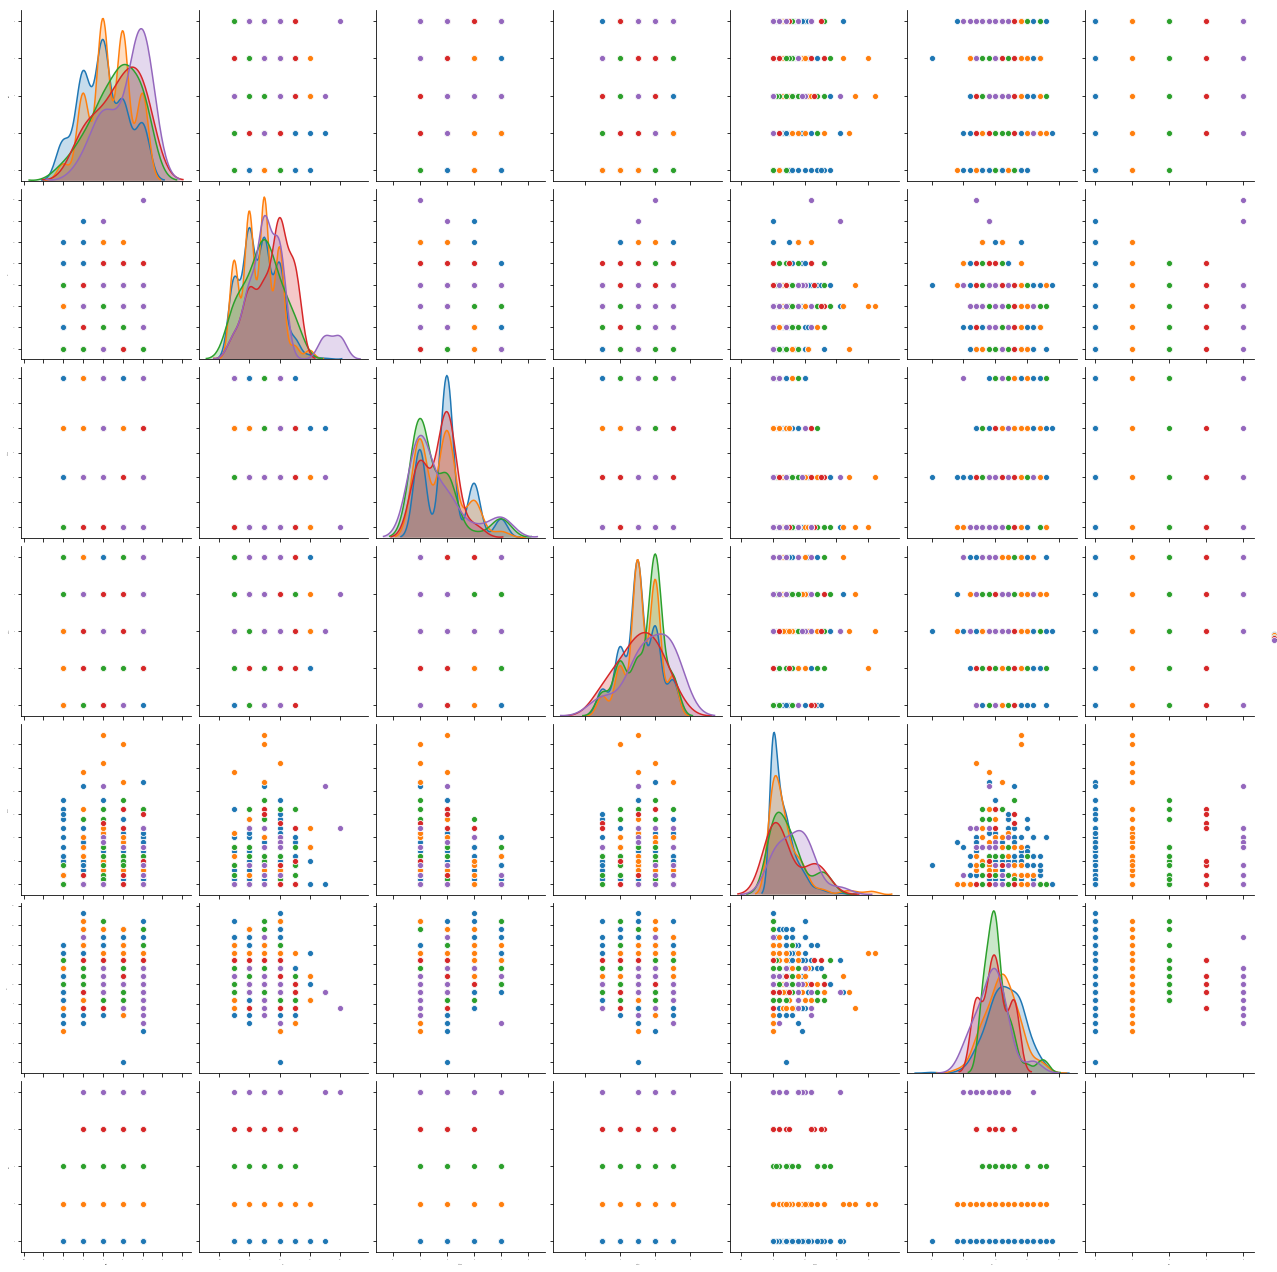

In [3]:
plt.figure(figsize=(100,100))
matplotlib.rcParams.update({'font.size': 1})
sns.pairplot(Data[["goout", "age", "studytime", "freetime", "absences", "G1", "Dalc"]], hue='Dalc')
plt.show()

In [4]:
y_d = Data.Dalc
y_w = Data.Walc
X = Data[["goout", "age", "studytime", "freetime", "absences", "G1"]]
X_categorical = pd.get_dummies(Data[["school", "sex", "freetime"]], columns=["school", "sex", "freetime"])
X = pd.concat([X, X_categorical], axis=1)
X.head()

,goout,age,studytime,freetime,absences,G1,school_GP,school_MS,sex_F,sex_M,freetime_1,freetime_2,freetime_3,freetime_4,freetime_5
0,4,18,2,3,4,0,1,0,1,0,0,0,1,0,0
1,3,17,2,3,2,9,1,0,1,0,0,0,1,0,0
2,2,15,2,3,6,12,1,0,1,0,0,0,1,0,0
3,2,15,3,2,0,14,1,0,1,0,0,1,0,0,0
4,2,16,2,3,0,11,1,0,1,0,0,0,1,0,0


## Разобьем данные на train и test

In [5]:
X_train, X_test, y_train_w, y_test_w, y_train_d, y_test_d = train_test_split(X, y_w, y_d, test_size=0.1, random_state=42)

## Обучим модель RandomForestRegressor

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def RandomForestR(X_train, X_test, y_walc_train, y_walc_test, y_dalc_train, y_dalc_test):
    forest_model_walc = RandomForestRegressor(random_state=1)
    forest_model_walc.fit(X_train, y_walc_train)
    melb_preds_walc = forest_model_walc.predict(X_test)
    forest_model_dalc = RandomForestRegressor(random_state=1)
    forest_model_dalc.fit(X_train, y_dalc_train)
    melb_preds_dalc = forest_model_dalc.predict(X_test)
    return (mean_absolute_error(melb_preds_dalc, y_dalc_test),
    mean_absolute_error(melb_preds_walc, y_walc_test))

print("mean_absolute_error (dalc, walc): {}".format(RandomForestR(X_train, X_test, y_train_w, y_test_w, y_train_d, y_test_d)))

mean_absolute_error (dalc, walc): (0.49910256410256415, 0.9708974358974359)


## Получили, что среднее отклонение walc, dalc меньше единицы. Отсюда можно сделать вывод, что наша модель работает не так уж и плохо. 

## Попробуем использовать XGBoost, чтобы добиться большей точности предсказаний.

In [7]:
from xgboost import XGBRegressor

my_model_d = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model_d.fit(X_train, y_train_d, verbose=False)
predictions_d = my_model_d.predict(X_test)
print("Mean absolute error for Dalc :{}".format(mean_absolute_error(predictions_d, y_test_d)))


my_model_w = XGBRegressor()
# Add silent=True to avoid printing out updates with each cycle
my_model_w.fit(X_train, y_train_w, verbose=False)
predictions_w = my_model_w.predict(X_test)
print("Mean absolute error for Walc :{}".format(mean_absolute_error(predictions_w, y_test_w)))

Mean absolute error for Dalc :0.5238522483752324
Mean absolute error for Walc :0.8929182896247276


## Посмотрим на точность модели

In [8]:
from sklearn.metrics import accuracy_score

print("Accuracy Dalc :{}".format(accuracy_score(y_test_d,np.round(predictions_d)).round(2)))
print("Accuracy Walc :{}".format(accuracy_score(y_test_w,np.round(predictions_w)).round(2)))

Accuracy Dalc :0.58
Accuracy Walc :0.31


## Вывод : с помощью XGBoost мы добились больших успехов, но accuracy оставляет желать лучшего, хотя среднее отклонение предсказанных результатов от правильных ответов не столь и велико. Также можно заметить, что ошибка предсказаний Walc заметно выше, что довольно странно, ведь может показаться, что Dalc и Walc должны зависеть от одних и тех же признаков одинаково.

# Построим интересные графики

In [9]:
fl = ["age", "Medu", "Fedu", "traveltime", "studytime", "failures", "famrel", "freetime", "goout", "health",
               "absences", "G1"]
categ = ["school", "sex","address", "famsize", "Pstatus", "Mjob", "Fjob", "reason", "guardian", "schoolsup",
                     "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]

In [10]:
import random
ERR_W = []
ERR_D = []
for j in range(100):
    Error_walc = []
    Error_dalc = []
    random.shuffle(fl)
    random.shuffle(categ)
    for i in range(2, 12):
        X_fl = Data[fl[:i]]
        X_categ = pd.get_dummies(Data[categ[:i]])
        X = pd.concat([X_fl, X_categ], axis=1)
        X_train, X_test, y_train_w, y_test_w, y_train_d, y_test_d = train_test_split(X, y_w, y_d, test_size=0.1, random_state=42)
        err = RandomForestR(X_train, X_test, y_train_w, y_test_w, y_train_d, y_test_d)
        Error_walc.append(err[1])
        Error_dalc.append(err[0])
    ERR_W.append(Error_walc)
    ERR_D.append(Error_dalc)

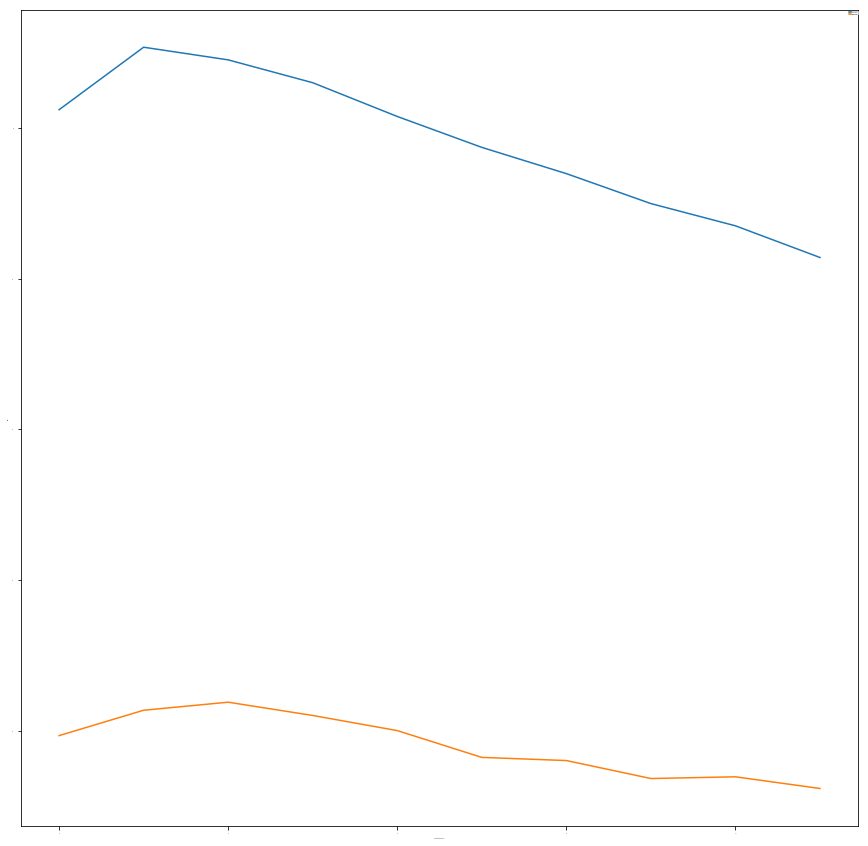

In [11]:
plt.figure(figsize=(15, 15))
ERR_W = np.array(ERR_W)
ERR_D = np.array(ERR_D)
ERR_W_mean = ERR_W.mean(axis=0)
ERR_D_mean = ERR_D.mean(axis=0)
plt.plot(range(2,12), ERR_W_mean, label='Walc MAE')
plt.plot(range(2,12), ERR_D_mean, label='Dalc MAE')
plt.xlabel("The futures quantity")
plt.ylabel("MAE")
plt.legend()